In [3]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install chromadb
#!pip install sentence-transformers
#!pip install langchain openai

In [4]:
import matplotlib.pyplot as plt

In [5]:
import os, sys
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import utils.chroma as chom

## Naive Retriever

In [6]:
file_path = '../data/RaptorContract.pdf'
pdftexts = chom.pdf_reader(file_path)
pdftexts[0]

'[R&G Draft 12.__.2021] \n112923184_5  \n \nSTOCK PURCHASE AGREEMENT \nBY AND AMONG \n[BUYER], \n[TARGET COMPANY], \nTHE SELLERS LISTED ON SCHEDULE I HERETO \nAND  \nTHE SELLERS ’ REPRESENTATIVE NAMED HEREIN \nDated as of [●]  \n \n[This document is intended solely to facilitate discussions among the parties identified herein.  \nNeither this document nor such discussions are intended to create, nor will either or both be \ndeemed to create, a legally binding or enforceable offer or agreement of any type or nature, \nunless and until a definitive written agreement is executed and delivered by each of th e parties \nhereto. \n \nThis document shall be kept confidential pursuant to the terms of the Confidentiality \nAgreement entered into by the parties and, if applicable, its affiliates with respect to the subject \nmatter hereof.]'

In [17]:
# character_split_texts = chom.text_splitter_chunks(pdftexts)
# print(character_split_texts[10])

from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    separator = "\n\n",
    chunk_size = 100,
    chunk_overlap = 100,
    is_separator_regex = False,
    model_name='text-embedding-3-small', #used to calculate tokens
    encoding_name='text-embedding-3-small'
)

character_split_texts = text_splitter.split_text('\n\n'.join(pdftexts))
print(f"\nTotal chunks: {len(character_split_texts)}")  
# text_splitter.create_documents(pdftexts)

Created a chunk of size 193, which is longer than the specified 100
Created a chunk of size 507, which is longer than the specified 100
Created a chunk of size 504, which is longer than the specified 100
Created a chunk of size 221, which is longer than the specified 100
Created a chunk of size 840, which is longer than the specified 100
Created a chunk of size 619, which is longer than the specified 100
Created a chunk of size 741, which is longer than the specified 100
Created a chunk of size 740, which is longer than the specified 100
Created a chunk of size 761, which is longer than the specified 100
Created a chunk of size 725, which is longer than the specified 100
Created a chunk of size 743, which is longer than the specified 100
Created a chunk of size 811, which is longer than the specified 100
Created a chunk of size 712, which is longer than the specified 100
Created a chunk of size 626, which is longer than the specified 100
Created a chunk of size 722, which is longer tha


Total chunks: 72


In [18]:
character_split_texts 

['[R&G Draft 12.__.2021] \n112923184_5  \n \nSTOCK PURCHASE AGREEMENT \nBY AND AMONG \n[BUYER], \n[TARGET COMPANY], \nTHE SELLERS LISTED ON SCHEDULE I HERETO \nAND  \nTHE SELLERS ’ REPRESENTATIVE NAMED HEREIN \nDated as of [●]  \n \n[This document is intended solely to facilitate discussions among the parties identified herein.  \nNeither this document nor such discussions are intended to create, nor will either or both be \ndeemed to create, a legally binding or enforceable offer or agreement of any type or nature, \nunless and until a definitive written agreement is executed and delivered by each of th e parties \nhereto. \n \nThis document shall be kept confidential pursuant to the terms of the Confidentiality \nAgreement entered into by the parties and, if applicable, its affiliates with respect to the subject \nmatter hereof.]',
 '-i- \n112923184_5 TABLE OF CONTENTS \nARTICLE I DEFINITIONS; CERTAIN RULES OF CONSTRUCTION .................................... 2  \nSection 1.01  Defin

In [19]:
token_split_texts = chom.sentence_transfomer_textsplitter(character_split_texts)
# print(token_split_texts[10])
print(f"\nTotal chunks: {len(token_split_texts)}")

2024-07-18 14:54:55.476762: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 14:54:56.135955: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 14:54:57.365142: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Total chunks: 237


In [20]:
from langchain.embeddings.openai import OpenAIEmbeddings
embed_model = OpenAIEmbeddings(model="text-embedding-ada-002")

embedding_fun = []
embedded_document = embed_model.embed_documents(character_split_texts)
embedding_fun.append(embedded_document)

In [21]:
embedding_function = chom.embedding(token_split_texts)
# print(embedding_function([token_split_texts[10]]))

In [22]:
import chromadb
def connect_with_chromadb(embedding_function, token_split_texts):
    chroma_client = chromadb.Client()
    chroma_collection = chroma_client.create_collection("microsoft_annual_report_20", embedding_function=embedding_function)

    ids = [str(i) for i in range(len(token_split_texts))]

    chroma_collection.add(ids=ids, documents=token_split_texts)
    chroma_collection.count()
    return chroma_collection

In [ ]:
"The study examines the relationship between friendship quality, academic achievement, and goal orientation in Latino students transitioning to middle school. It found a negative link between negative friendship quality and academic achievement, and positive friendship quality affecting girls' goal orientation decrease."


In [23]:
chroma_collection = connect_with_chromadb(embedding_function, token_split_texts)
# chroma_collection.count()

In [44]:
chroma_collection

def vectordb_answer_question(query, chroma_collection):
    # query = "What was the total revenue?"
    results = chroma_collection.query(query_texts=[query], n_results=500)
    retrieved_documents = results['documents'][0]

    # for document in retrieved_documents:
    #     print(document)
    #     print('\n')
    return retrieved_documents


In [ ]:
# query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"
query = "Is the escrow amount greater than the retention amount?"
retrieved_documents = vectordb_answer_question(query, chroma_collection)
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

In [48]:
retrieved_documents[6]

'legal counsel, accountants, consultants and other experts and advisors so incurred and ( iii ) all change of control payments ; ( b ) any fees and expenses owing to the company ’ s affiliates ( other than to another acquired company ) or to any seller ( in each case, whether or not arising in connection with this agreement or the contemplated transactions but excluding compensation ) ; ( c ) 50 % of all fees and expenses of the escrow agent under the escrow agreement, ( d ) 50 % of all premiums paid in connection with the r & w insurance policy, ( e ) the employer portion of any payroll tax of any acquired company attributable to consideration payable under this agreement respect to the optionholders ( calculated without regard to any deferral available under the cares act ), ( f ) any transfer taxes and ( g ) 100 % of the fees, costs and expenses incurred in connection with the “ tail ” directors ’ and officers ’ liability and fiduciary liability insurance policies obtained pursuant 

In [69]:
import numpy as np
#cross encoder reranker
from sentence_transformers import CrossEncoder

def reranker(query):
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

    # query_text = "Is the escrow amount greater than the retention amount?";
    query_text = query
    # query_text = "Would the aggregate amount payable by the Buyer to the Sellers be affected if it is determined that the actual Closing Debt Amount is greater the estimated Closing Debut Amount?"
    # result = parent_document_retriever_wrapper(query_text)
    pairs = [[query_text, doc] for doc in retrieved_documents]

    # Predict scores for pairs
    scores = cross_encoder.predict(pairs)
    # Print scores
    # print("Scores:")
    for score in scores:
        f"{score:.2f}"

    # Order the documents by score in descending order
    ordered_indices = np.argsort(scores)[::-1]

    # print("New Ordering:")
    for i in ordered_indices:
        f"{i+1}. {retrieved_documents[i]}"

    # Create an array of the top-scored documents to pass to an LLM as context
    top_scored_docs = [retrieved_documents[i] for i in ordered_indices[:15]]
    return top_scored_docs

In [83]:
query = "Is the escrow amount greater than the retention amount?"
top_docs = reranker(query)
output_answer = chom.openai_model_answer(query=query, retrieved_documents=top_docs)
print(output_answer)

The escrow amount is $1,000,000 according to the information provided. The retention amount is $5,000,000. Therefore, the escrow amount is less than the retention amount.


In [71]:
top_docs

['##mation of the contemplated transactions or result in a liability of the acquired companies or buyer. section 4. 06 no brokers. except as disclosed in schedule 4. 06, such seller has no liability that is or expected to be borne by any acquired company or the buyer to any broker, finder or agent with respect to the contemplated transactions, and such seller agrees to satisfy in full any liability required to be disclosed on schedule 4. 06. article v representations and warranties of the buyer. the buyer represents and warrants to the sellers that : section 5. 01 organization. the buyer is duly organized, validly existing and in good standing under the laws of the jurisdiction of its organization.',
 '......... 38 article iv individual representations and warranties of the sellers...................................................................................................................................... 38 section 4. 01 organization............................................

In [ ]:
import pandas as pd
import pprint
evaluation = pd.read_csv('../data/RaptorQA.csv')

answers = []
contexts = []
for question in evaluation['question']:
    docs = reranker(question)
    answer = chom.openai_model_answer(query=question, retrieved_documents=docs)
    pprint.pp(answer)
    answers.append(answer)
    
    context = [doc for doc in docs]
    contexts.append(context)

evaluation['answer'] = answers
evaluation['contexts'] = contexts
# evaluation.head()
evaluation.to_csv('../data/updated_raptor_crossendoderReranker_evaluation.csv', index=False)

# UMAP

In [ ]:
# !pip install umap-learn

In [ ]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

In [ ]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [ ]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 17/17 [00:10<00:00,  1.64it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

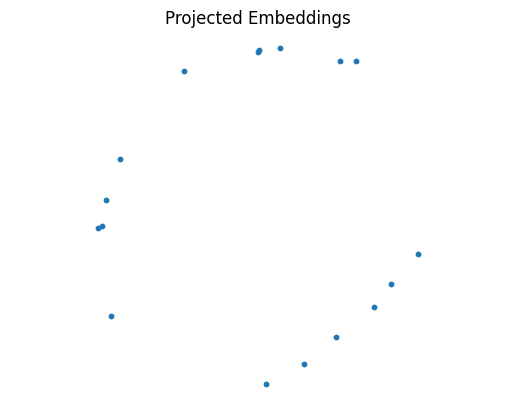

In [ ]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

# Relevancy and Distraction

In [ ]:
query = "Under what circumstances and to what extent the Sellers are responsible for a breach of representations and warranties?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

providing the company a prompt written notice and subject to promptl y cooperate with the company in seeking a protective order. 3. safeguard : the advisor shall safeguard the confidential information, keep it in strict confidence and shall not disclose it to any third party without the prior written consent of the company. 4. ip : any work product, upon creation, shall be fully and exclusivel y owned by the company. the advisor, immediately upon company ’ s request, shall sign any document and / or perform any action neede d to formalize such ownership. the advisor shall not obtain any righ ts in the work product, including moral rights and / or rights for royalties or ot her consideration under any applicable law ( including section 134 of the israeli patent law – 1967 if applicable ), and shall not be entitled to any compe nsation with respect to the services, which was not specifically agreed, in writing, between the advisor and the comp any.

7. third parties : the advisor represe

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

Sellers are responsible for breach of representations and warranties if they fail to provide prompt written notices and cooperate to seek protective orders as per agreement terms.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

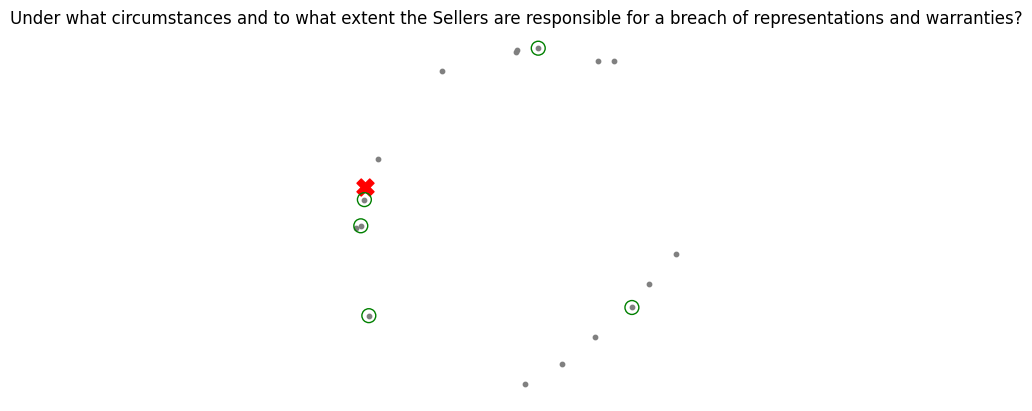

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "How much is the escrow amount in value?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

this agreement may not be 

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The value of the escrow amount is not provided in the information given.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

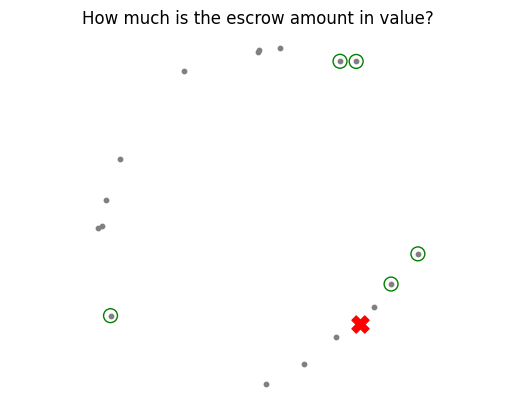

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "How much is the escrow amount?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

- 2 - 4. term : the term of this agreement shall commence on the effective date and shall continue until terminated in accordance with the provisions herein ( the " term " ). 5. termination : either party, at any given time, may terminate this agreement, for any reason whatsoever, with or without cause, upon fourteen ( 14 ) days ’ prior written notice. notwithstanding the above, the company may terminate this agreement immediately and without prior notice if advisor refuses or is unable to perform the services, or is in breach of any provision of this agreement. 6. compensation : 6. 1 as full and sole consideration for the services, and subject to the performance of the services, the company shall pay the advisor, against an invoice provided to the company by advisor, hourly fees at a rate of usd 9 ( nine ) per billable hour as defined below, limited to a maximum of usd 1, 500 per month ( the " fees " ). in addition, the company shall pay the advisor usd 100

- 3 - constitute salary pa

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The escrow amount is not mentioned in the provided information.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

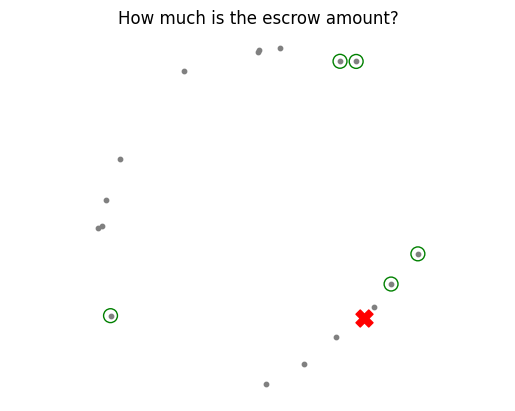

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
query = "Are there any conditions to the closing?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(document)
    print('')

5. non - compete : during the term of engagement with the company and for a period of 12 months thereafter, advisor shall not be involved, as an employee, owner, contractor or otherwise, in any business, which competes with the company ’ s business, and shall not solicit and / or hire any employee and / or service provider of the company, without the prior written consent of the company. 6. personnel : the advisor may provide the services only directly or through employees, contractors or agents ( “ personnel ” ), which were specifically approved by the company, and have committed in writ ing to confidentiality and ownership rights towards the advisor and / or the company, in a form restrictive enough to allow advisor to comply and enforce the commitments under this undertaking ( “ authorized personnel ” ). without limiting the foregoing, the advisor is liable hereunder for any breach of this undertaking by any advisor personne l.

- 2 - 4. term : the term of this agreement shall comme

In [ ]:
output_answer = chom.openai_model_answer(query=query, retrieved_documents=retrieved_documents)
print(output_answer)

The conditions for closing include a non-compete clause, termination clauses, compensation details, specifics about authorized personnel, and jurisdiction rules.


In [ ]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


(-4.462840829417109,
 0.3433709111064672,
 14.068113040924072,
 19.118206310272218)

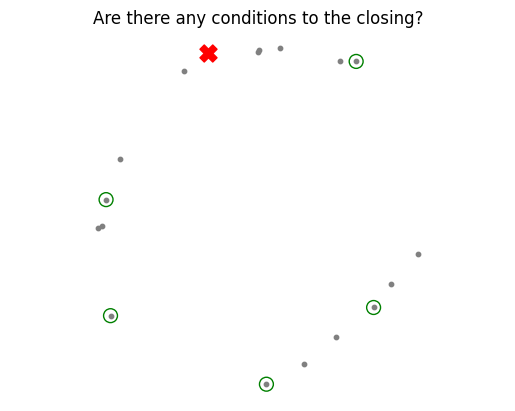

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')